## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [136]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

import torch.nn.functional as F
import torch

# from keras.models import Sequential
# from keras.layers import Dense
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import preprocessing

from generate_TF import GenerateTF
from scipy.optimize import curve_fit
from prettytable import PrettyTable
%matplotlib widget

In [115]:
def plot_loss(loss, val_loss, epoch=(-1, -1)):
    fig = plt.figure()

    if epoch[0] == -1:
        start_idx = 0
    else:
        start_idx = epoch[0]

    if epoch[1] == -1:
        end_idx = len(loss)
    else:
        end_idx = epoch[1]
    loss = loss[start_idx: end_idx]
    val_loss = val_loss[start_idx: end_idx]
    plt.plot(np.arange(start_idx, end_idx), loss, label='train')
    plt.plot(np.arange(start_idx, end_idx), val_loss, label='validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    plt.close()


In [117]:
# Load the data
df = pd.read_pickle('./data/transfer-functions-82000.pkl')
df.head()

,phi,g_oo,x,y
0,-20.0,0.000100,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-22.425862483348567, -34.50558003150795, -39...."
1,-20.0,0.000621,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-17.111296708758623, -19.276097087349733, -21..."
2,-20.0,0.001142,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-37.10041261060839, -21.007891272269745, -20...."
3,-20.0,0.001663,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-23.37838521227782, -24.835608713413627, -24...."
4,-20.0,0.002184,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-21.79184944021594, -28.996907099851697, -27...."


In [118]:
phi_encoder = preprocessing.LabelEncoder()
df['phi_label'] = phi_encoder.fit_transform(df['phi'])
print(phi_encoder.classes_)

gain_encoder = preprocessing.LabelEncoder()
df['g_oo_label'] = gain_encoder.fit_transform(df['g_oo'])
print(gain_encoder.classes_)

print(df.dtypes)

[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
[0.0001     0.00062105 0.00114211 0.00166316 0.00218421 0.00270526
 0.00322632 0.00374737 0.00426842 0.00478947 0.00531053 0.00583158
 0.00635263 0.00687368 0.00739474 0.00791579 0.00843684 0.00895789
 0.00947895 0.01      ]
phi           float64
g_oo          float64
x              object
y              object
phi_label       int64
g_oo_label      int64
dtype: object


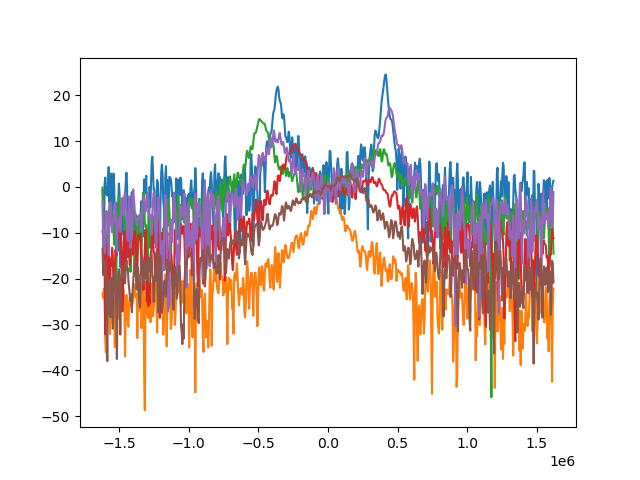

In [119]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [120]:
# Extract the target variables
param_a_label = df.pop('phi_label')
param_b_label = df.pop('g_oo_label')

param_a = df.pop('phi')
param_b = df.pop('g_oo')

# All x should be equal
x = df.iloc[0].x.astype(np.float32)
df.drop(columns='x', inplace=True)

In [121]:
# target is the target vector
target = np.array((param_a_label, param_b_label), dtype=np.uint8).T

target_original = np.array((param_a, param_b)).T

# target = tf.convert_to_tensor(target, dtype=tf.uint8)
print(target[5:15])


[[ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]]


In [122]:
df.head()

,y
0,"[-22.425862483348567, -34.50558003150795, -39...."
1,"[-17.111296708758623, -19.276097087349733, -21..."
2,"[-37.10041261060839, -21.007891272269745, -20...."
3,"[-23.37838521227782, -24.835608713413627, -24...."
4,"[-21.79184944021594, -28.996907099851697, -27...."


In [123]:
values = np.zeros((len(df), len(df.iloc[0, 0])), dtype=np.float32)
# print(values.shape)
for index, row in df.iterrows():
    values[index, :] = row.values[0]
print(values.shape)
print(type(values))

(82000, 662)
<class 'numpy.ndarray'>


In [124]:
# Convert data to torch tensor
data_scaler = preprocessing.StandardScaler().fit(values)
scaled_values = data_scaler.transform(values)
data = scaled_values
# data = tf.convert_to_tensor(scaled_values, dtype=tf.float32)
print(data)

[[-1.2695345  -2.2140377  -2.7279968  ... -0.94527686 -1.364626
  -2.3427405 ]
 [-0.7820416  -0.7954014  -0.98608685 ... -0.7045489  -0.7330355
  -2.1319206 ]
 [-2.6155975  -0.95671916 -0.938509   ... -0.9319991  -1.022017
  -1.4073564 ]
 ...
 [ 0.16261247  0.35903206  0.256929   ... -0.38136348 -0.23624879
   0.39377823]
 [-0.3496965   0.5653598   0.5511214  ...  0.57616895  0.7126734
   0.07814208]
 [-0.06349966  0.6009624   0.6839679  ...  0.00995951  0.1177445
   0.4430453 ]]


In [125]:
# Split in train and test
X_train, X_test, y_train, y_test, y_train_original, y_test_original = train_test_split(
    data, target, target_original, test_size=0.2, random_state=2)

# further divide X_test in test + validate
X_test, X_validate, y_test, y_validate, y_test_original, y_validate_original = train_test_split(
    X_test, y_test, y_test_original, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)

(65600, 662)
(13120, 662)
(3280, 662)
(65600, 2)
(13120, 2)
(3280, 2)


In [126]:
# convert to tensors
# Not needed for now

In [127]:
def get_model(n_inputs, n_outputs, name='classifer', activation_func='relu',
              hidden_1=140, hidden_2=110, hidden_3=0,
              kernel_size=10, stride=10, trim_edges=120, save_best=True):
    model = tf.keras.models.Sequential([
        keras.Input(shape=(n_inputs,1)),
        keras.layers.Cropping1D(cropping=trim_edges),
        keras.layers.AveragePooling1D(pool_size=kernel_size, strides=stride),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden_1, activation=activation_func),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(hidden_2, activation=activation_func),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(n_outputs, activation='softmax')
    ])
    return model


In [128]:
n_inputs = values.shape[1]
n_outputs = len(phi_encoder.classes_)

model1 = get_model(n_inputs, n_outputs, name='classifier1', activation_func='gelu',
                   hidden_1=420, hidden_2=140, hidden_3=0,
                   kernel_size=4, stride=4, trim_edges=130, save_best=True)
print(model1.summary())

model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
               loss="sparse_categorical_crossentropy",
               metrics=['accuracy'])

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping1d_20 (Cropping1D)  (None, 402, 1)            0         
                                                                 
 average_pooling1d_22 (Avera  (None, 100, 1)           0         
 gePooling1D)                                                    
                                                                 
 flatten_7 (Flatten)         (None, 100)               0         
                                                                 
 dense_66 (Dense)            (None, 420)               42420     
                                                                 
 dropout_44 (Dropout)        (None, 420)               0         
                                                                 
 dense_67 (Dense)            (None, 140)               58940     
                                                     

In [131]:
# train the network
phase_history = model1.fit(
    X_train.reshape((len(X_train),-1,1)),
    y_train[:, 0],  epochs=40, batch_size=32,
    validation_data=(X_test.reshape((len(X_test), -1, 1)), y_test[:, 0]))
# train_loss1, train_accuracy1, test_loss1, test_accuracy1 = model1.train_net(
#     optimizer1, criterion, X_train, y_train[:, 0].view(-1,), X_test, y_test[:, 0].view(-1,), 500)

2050/2050 [==============================] - 3s 1ms/step - loss: 1.0756 - accuracy: 0.5719 - val_loss: 0.9283 - val_accuracy: 0.6324
Epoch 41/100
2050/2050 [==============================] - 3s 1ms/step - loss: 1.0666 - accuracy: 0.5746 - val_loss: 0.9744 - val_accuracy: 0.6106
Epoch 42/100
2050/2050 [==============================] - 3s 1ms/step - loss: 1.0673 - accuracy: 0.5764 - val_loss: 0.9876 - val_accuracy: 0.6104
Epoch 43/100
2050/2050 [==============================] - 3s 1ms/step - loss: 1.0696 - accuracy: 0.5752 - val_loss: 0.9285 - val_accuracy: 0.6302
Epoch 44/100
2050/2050 [==============================] - 3s 1ms/step - loss: 1.0642 - accuracy: 0.5751 - val_loss: 0.9223 - val_accuracy: 0.6370
Epoch 45/100
2050/2050 [==============================] - 3s 1ms/step - loss: 1.0644 - accuracy: 0.5791 - val_loss: 0.9477 - val_accuracy: 0.6209
Epoch 46/100
2050/2050 [==============================] - 3s 1ms/step - loss: 1.0600 - accuracy: 0.5812 - val_loss: 0.9411 - val_accuracy

KeyboardInterrupt: 

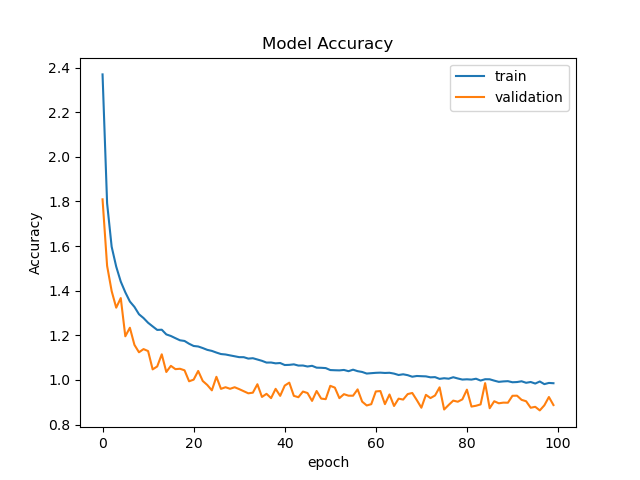

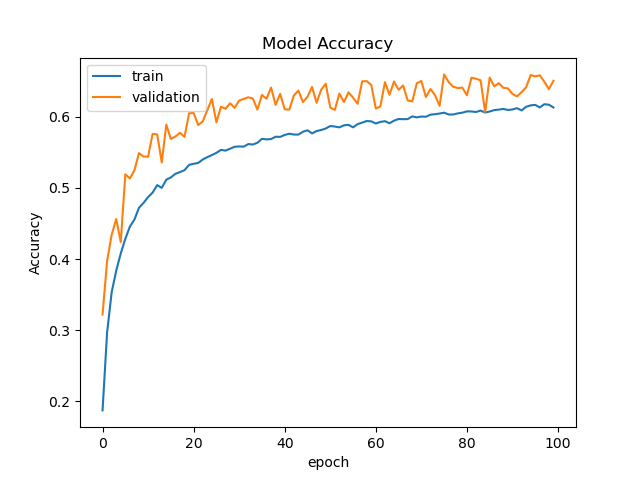

In [ ]:
plot_loss(phase_history.history['loss'], phase_history.history['val_loss'], epoch=(0, -1))
plot_loss(phase_history.history['accuracy'], phase_history.history['val_accuracy'], epoch=(0,-1 ))

In [132]:
n_inputs = values.shape[1]
n_outputs = len(phi_encoder.classes_)

model2 = get_model(n_inputs, n_outputs, name='classifier2', activation_func='gelu',
                   hidden_1=420, hidden_2=350, hidden_3=0,
                   kernel_size=4, stride=4, trim_edges=120, save_best=True)
print(model2.summary())

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
               loss="sparse_categorical_crossentropy",
               metrics=['accuracy'])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping1d_21 (Cropping1D)  (None, 422, 1)            0         
                                                                 
 average_pooling1d_23 (Avera  (None, 105, 1)           0         
 gePooling1D)                                                    
                                                                 
 flatten_8 (Flatten)         (None, 105)               0         
                                                                 
 dense_69 (Dense)            (None, 420)               44520     
                                                                 
 dropout_46 (Dropout)        (None, 420)               0         
                                                                 
 dense_70 (Dense)            (None, 350)               147350    
                                                     

In [133]:
# train the network
gain_history = model2.fit(
    X_train.reshape((len(X_train),-1,1)),
    y_train[:, 1],  epochs=40, batch_size=32,
    validation_data=(X_test.reshape((len(X_test), -1, 1)), y_test[:, 1]))

Epoch 1/40
2050/2050 [==============================] - 3s 2ms/step - loss: 0.7998 - accuracy: 0.7172 - val_loss: 0.5203 - val_accuracy: 0.7715
Epoch 2/40
2050/2050 [==============================] - 3s 1ms/step - loss: 0.7905 - accuracy: 0.6773 - val_loss: 0.6741 - val_accuracy: 0.7088
Epoch 3/40
2050/2050 [==============================] - 3s 1ms/step - loss: 0.8295 - accuracy: 0.6494 - val_loss: 0.5702 - val_accuracy: 0.7427
Epoch 4/40
2050/2050 [==============================] - 3s 1ms/step - loss: 0.9576 - accuracy: 0.6157 - val_loss: 0.7899 - val_accuracy: 0.6604
Epoch 5/40
2050/2050 [==============================] - 3s 1ms/step - loss: 0.9264 - accuracy: 0.6195 - val_loss: 0.7199 - val_accuracy: 0.6960
Epoch 6/40
2050/2050 [==============================] - 3s 1ms/step - loss: 0.9318 - accuracy: 0.6209 - val_loss: 0.7424 - val_accuracy: 0.6819
Epoch 7/40
2050/2050 [==============================] - 3s 1ms/step - loss: 0.8955 - accuracy: 0.6300 - val_loss: 0.6713 - val_accuracy:

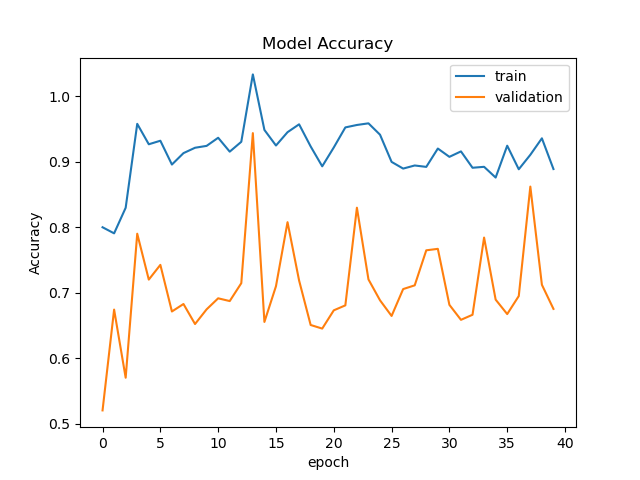

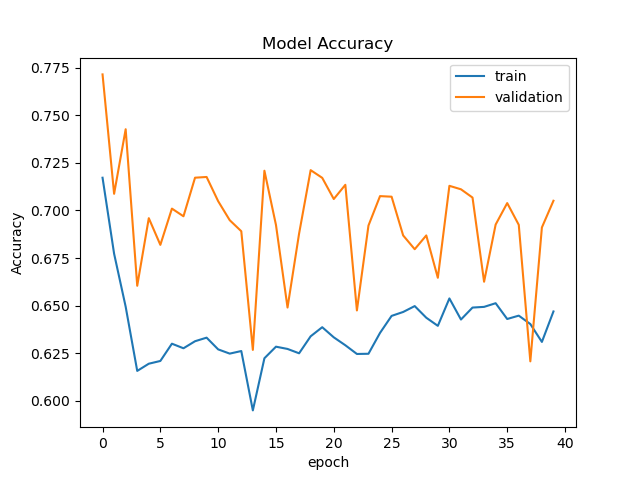

In [134]:
plot_loss(gain_history.history['loss'], gain_history.history['val_loss'], epoch=(0, -1))
plot_loss(gain_history.history['accuracy'], gain_history.history['val_accuracy'], epoch=(0,-1 ))

In [137]:
def curve_fit_deluxe(func, freq, sample, trim_edges=0, kernel_size=1, stride=1, **kwargs):
    # center crop sample
    if trim_edges > 0:
        freq, sample = freq[trim_edges:-trim_edges], sample[trim_edges:-trim_edges]
    # convert to tensor for average pooling
    freq = torch.tensor(freq).view(1, -1)
    sample = torch.tensor(sample).view(1, -1)
    # average pool sample
    freq = F.avg_pool1d(freq, kernel_size=kernel_size, stride=stride).ravel().numpy()
    sample = F.avg_pool1d(sample, kernel_size=kernel_size, stride=stride).ravel().numpy()
    return curve_fit(func, freq, sample, **kwargs)

In [138]:
# Get model's predictions

y_pred_phase = model1.predict(X_validate).argmax(axis=-1)
y_pred_gain = model2.predict(X_validate).argmax(axis=-1)

# Get curve fit predictions
gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
freq = gen_tf.frequency.astype(np.float32)
y_optimizer = []
for sample in X_validate:
    popt, _ = curve_fit_deluxe(gen_tf, freq, sample, trim_edges=130, kernel_size=4, stride=1,
                                    bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
    y_optimizer.append(popt)
y_optimizer = np.array(y_optimizer)

103/103 [==============================] - 0s 1ms/step


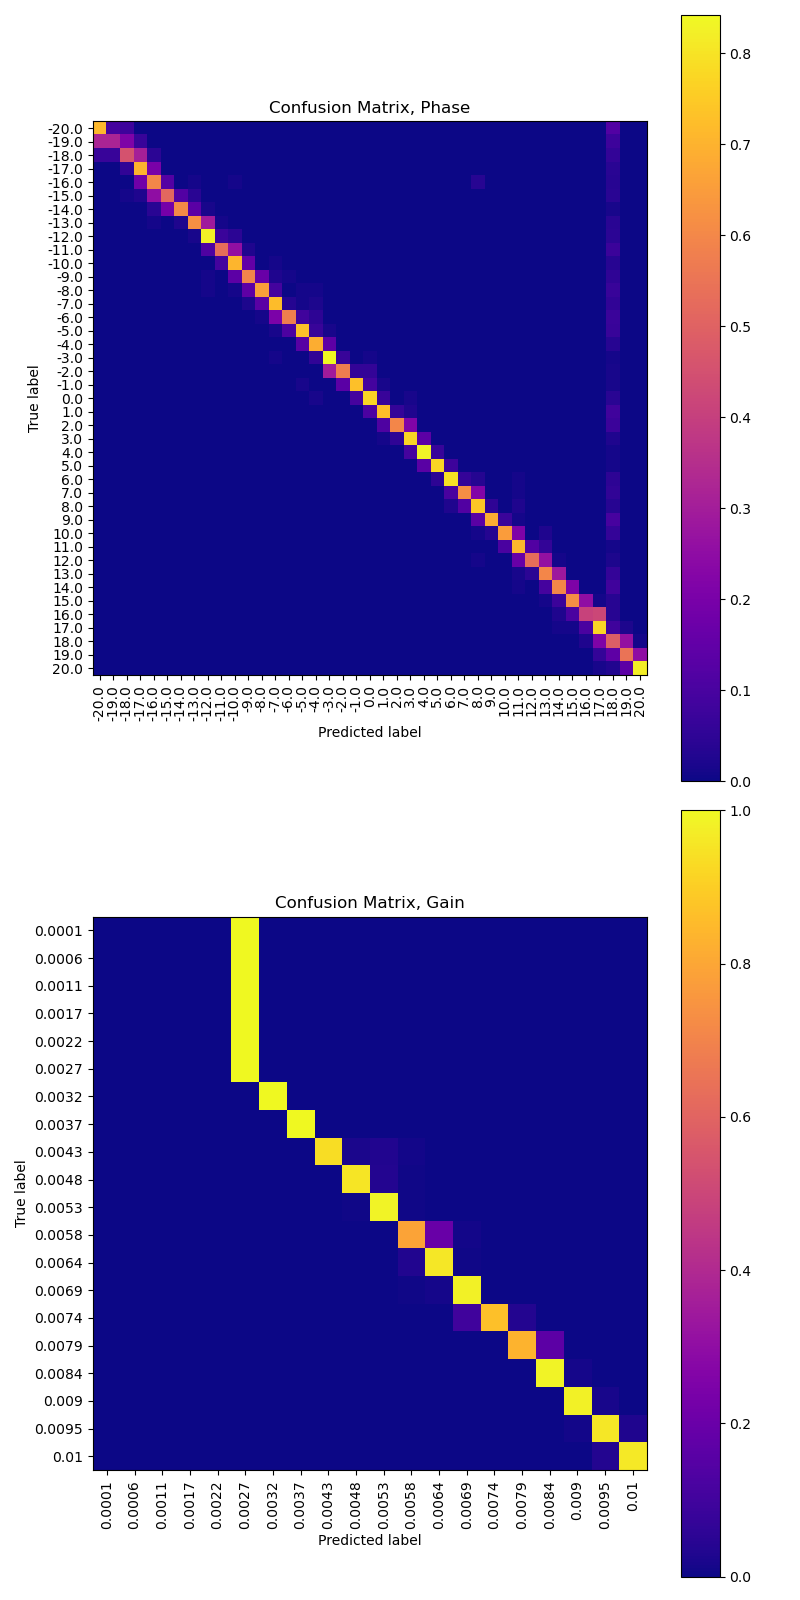

In [139]:
# show confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, (ax1, ax2) = plt.subplots(figsize=(8, 16), nrows=2)
ax1.set_title('Confusion Matrix, Phase')
ConfusionMatrixDisplay.from_predictions(y_validate[:, 0], y_pred_phase,
                                        xticks_rotation='vertical', ax=ax1,
                                        normalize='true', include_values=False,
                                        cmap='plasma', display_labels=phi_encoder.classes_)
plt.sca(ax1)
plt.tight_layout()

ax2.set_title('Confusion Matrix, Gain')
ConfusionMatrixDisplay.from_predictions(y_validate[:, 1], y_pred_gain,
                                        xticks_rotation='vertical', ax=ax2,
                                        include_values=False, normalize='true',
                                        cmap='plasma',
                                        display_labels=np.round(gain_encoder.classes_, 4))
plt.sca(ax2)
plt.tight_layout()

In [ ]:
# Define a simple model

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

In [ ]:
# evaluate our model
def evaluate_model(X, y):
    results = list()
    n_inputs = X.shape[1]
    n_outputs = y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = tf.gather(X, train_ix), tf.gather(X, test_ix)
        y_train, y_test = tf.gather(y, train_ix), tf.gather(y, test_ix)

        # X_train, X_test = tf_data[train_ix], tf_data[test_ix]
        # y_train, y_test = tf_target[train_ix], tf_target[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    print('MAE: %3f (%.3f)' % (np.mean(results), np.std(results)))
    return results

In [ ]:
n_inputs = tf_data.shape[1]
n_outputs = tf_target.shape[1]
train_ix, test_ix = train_test_split(np.arange(tf_data.shape[0]), test_size=0.05)
X_train, X_test = tf.gather(tf_data, train_ix), tf.gather(tf_data, test_ix)
y_train, y_test = tf.gather(tf_target, train_ix), tf.gather(tf_target, test_ix)
model = get_model(n_inputs, n_outputs)
# fit model
print('Fitting the model')
history = model.fit(X_train, y_train, validation_split=0.05, verbose=0, epochs=400)
# evaluate model on test set
print('Evaluating the model')
mae = model.evaluate(X_test, y_test, verbose=1)
# store result
print('MAE: %.3f' % mae)

In [ ]:
# plot history
% matplotlib widget

def plot_loss(loss, val_loss, epoch=(-1, -1)):
    fig = plt.figure()

    if epoch[0] == -1:
        start_idx = 0
    else:
        start_idx = epoch[0]

    if epoch[1] == -1:
        end_idx = len(loss)
    else:
        end_idx = epoch[1]
    loss = loss[start_idx: end_idx]
    val_loss = val_loss[start_idx: end_idx]
    plt.plot(np.arange(start_idx, end_idx), loss, label='train')
    plt.plot(np.arange(start_idx, end_idx), val_loss, label='validation')
    plt.title('Model Accuracy')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()


plot_loss(history.history['loss'], history.history['val_loss'], epoch=(-1, -1))

In [ ]:
# make predictions, and plot them
random_idx = np.random.choice(np.arange(len(X_test)), size=5, replace=False)
X_validate = tf.gather(X_test, random_idx)
y_validate = tf.gather(y_test, random_idx)
yhat = model.predict(X_validate)
print('Original: ', y_validate)
print('Predicted:', yhat)

In [ ]:
# plot the validation curves
# %matplotlib inline
% matplotlib widget
from scipy.optimize import curve_fit

plt.figure(figsize=(10, 10))
for idx in range(len(y_validate)):
    y_real = func(x, *y_validate[idx])
    y_pred = func(x, *yhat[idx])
    popt, pcov = curve_fit(func, x, X_validate[idx])
    p = plt.plot(x, y_real, label=f'y_real{idx}', ls='-')
    plt.plot(x, y_pred, label=f'y_pred{idx}', ls='--', color=p[0].get_color())
    plt.plot(x, func(x, *popt), label=f'y_opt{idx}', ls=':', color=p[0].get_color())
plt.legend(ncol=3)
plt.show()